RLLTE provides evaluation methods based on:

> - Agarwal R, Schwarzer M, Castro P S, et al. Deep reinforcement learning at the edge of the statistical precipice[J]. Advances in neural information processing systems, 2021, 34: 29304-29320.

We reconstruct and improve the code of the official repository [rliable](https://github.com/google-research/rliable), achieving higher convenience and efficiency.

# Download Data

Suppose we want to evaluate algorithm performance on the [Procgen](https://github.com/openai/procgen) benchmark. First, download the data from [rllte-hub](https://hub.rllte.dev/):

In [1]:
import os
import sys

sys.path.append("/export/yuanmingqi/code/rllte")

In [2]:
# load packages
from rllte.evaluation import Performance, Comparison, min_max_normalize
from rllte.hub.datasets import Procgen, Atari
import numpy as np

In [3]:
# load scores
procgen = Procgen()
procgen_scores = procgen.load_scores()
print(procgen_scores.keys())

dict_keys(['ppg', 'mixreg', 'ppo', 'idaac', 'plr', 'ucb-drac'])


In [4]:
# get ppo-normalized scores
ppo_norm_scores = dict()
MIN_SCORES = np.zeros_like(procgen_scores['ppo'])
MAX_SCORES = np.mean(procgen_scores['ppo'], axis=0)
for algo in procgen_scores.keys():
    ppo_norm_scores[algo] = min_max_normalize(procgen_scores[algo],
                                              min_scores=MIN_SCORES,
                                              max_scores=MAX_SCORES)

For each algorithm, this will return a `NdArray` of size (`10` x `16`) where scores[n][m] represent the score on run `n` of task `m`.


# 1. Performance Evaluation of Single Algorithm

Initialize the performance evaluator:

In [8]:
perf = Performance(scores=ppo_norm_scores['ppo'], 
                   get_ci=True # get confidence intervals
                  )

In [7]:
# computes mean of sample mean scores per task.
perf.aggregate_mean()

(1.0,
 array([[0.97356522],
        [1.02581304]]))

In [9]:
# computes median of sample mean scores per task.
perf.aggregate_median()

(1.0,
 array([[0.98788833],
        [1.01211777]]))

In [10]:
# computes optimality gap across all runs and tasks.
perf.aggregate_og()

(0.05484655070269717,
 array([[0.04044561],
        [0.06969737]]))

In [11]:
# computes the interquartile mean across runs and tasks.
perf.aggregate_iqm()

(1.000982017825453,
 array([[0.98629746],
        [1.01541494]]))

# 2. Performance Comparison of Multiple Algorithms


`Comparison` module allows you to compare the performance between two algorithms:

In [12]:
# compute the overall probability of imporvement of algorithm `X` over `Y`.
comp = Comparison(scores_x=ppo_norm_scores['ppg'],
                  scores_y=ppo_norm_scores['ppo'],
                  get_ci=True)
comp.compute_poi()

(0.8153125,
 array([[0.78125   ],
        [0.84876562]]))

This indicates the overall probability of imporvement of `PPG` over `PPO` is `0.8153125`.

# 3. Metrics Visualization

In [16]:
from rllte.evaluation import (plot_interval_estimates,
                              plot_probability_improvement,
                              plot_sample_efficiency_curve,
                              plot_performance_profile)

## 3.1 plot_interval_estimates

`.plot_interval_estimates` can plot various performance metrics of algorithms with stratified confidence intervals. Take [Procgen](https://github.com/openai/procgen) for example, we want to plot four reliable metrics computed by `Performance` evaluator:

In [13]:
# construct a performance dict
aggregate_performance_dict = {
    "MEAN": {},
    "MEDIAN": {},
    "IQM": {},
    "OG": {}
}
for algo in ppo_norm_scores.keys():
    perf = Performance(scores=ppo_norm_scores[algo], get_ci=True)
    aggregate_performance_dict['MEAN'][algo] = perf.aggregate_mean()
    aggregate_performance_dict['MEDIAN'][algo] = perf.aggregate_median()
    aggregate_performance_dict['IQM'][algo] = perf.aggregate_iqm()
    aggregate_performance_dict['OG'][algo] = perf.aggregate_og()

plot all the four metrics of all the algorithms:

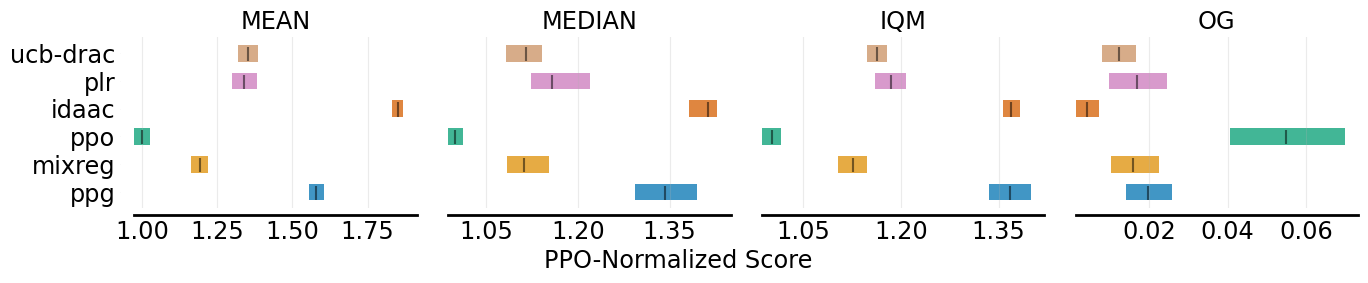

In [17]:
fig, axes = plot_interval_estimates(aggregate_performance_dict,
                                    metric_names=['MEAN', 'MEDIAN', 'IQM', 'OG'],
                                    algorithms=['ppg', 'mixreg', 'ppo', 'idaac', 'plr', 'ucb-drac'],
                                    xlabel="PPO-Normalized Score")
fig.savefig('./plot_interval_estimates1.png', format='png', bbox_inches='tight')

plot two metrics of all the algorithms

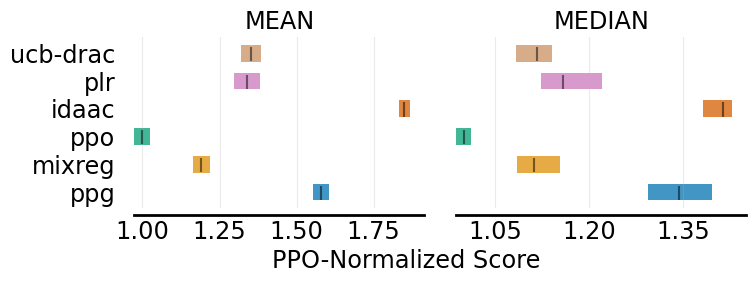

In [18]:
fig, axes = plot_interval_estimates(aggregate_performance_dict,
                        metric_names=['MEAN', 'MEDIAN'],
                        algorithms=['ppg', 'mixreg', 'ppo', 'idaac', 'plr', 'ucb-drac'],
                        xlabel="PPO-Normalized Score")
fig.savefig('./plot_interval_estimates2.png', format='png', bbox_inches='tight')

plot two metrics of three algorithms

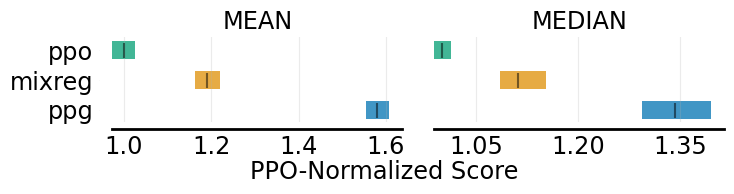

In [21]:
fig, axes = plot_interval_estimates(aggregate_performance_dict,
                        metric_names=['MEAN', 'MEDIAN'],
                        algorithms=['ppg', 'mixreg', 'ppo'],
                        xlabel="PPO-Normalized Score",
                        xlabel_y_coordinate=-0.4)
fig.savefig('./plot_interval_estimates3.png', format='png', bbox_inches='tight')

## 3.2 plot_probability_improvement

`.plot_probability_improvement` plots probability of improvement with stratified confidence intervals. An example is:

In [22]:
# construct a comparison dict
pairs = [['idaac', 'ppg'], ['idaac', 'ucb-drac'], ['idaac', 'ppo'],
    ['ppg', 'ppo'], ['ucb-drac', 'plr'], 
    ['plr', 'mixreg'], ['ucb-drac', 'mixreg'],  ['mixreg', 'ppo']]

probability_of_improvement_dict = {}
for pair in pairs:
    comp = Comparison(scores_x=ppo_norm_scores[pair[0]], 
                      scores_y=ppo_norm_scores[pair[1]],
                      get_ci=True)
    probability_of_improvement_dict['_'.join(pair)] = comp.compute_poi()

Plot the comparison figure:

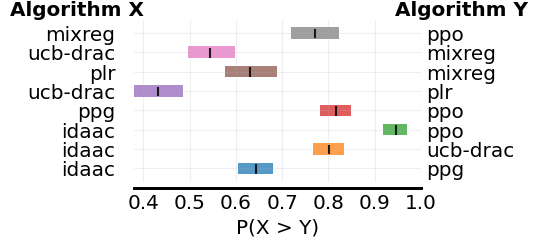

In [23]:
fig, ax = plot_probability_improvement(poi_dict=probability_of_improvement_dict)
fig.savefig('./plot_probability_improvement.png', format='png', bbox_inches='tight')

# 3.3 plot_performance_profile

`.plot_performance_profile` plots performance profiles with stratified confidence intervals. An example is:

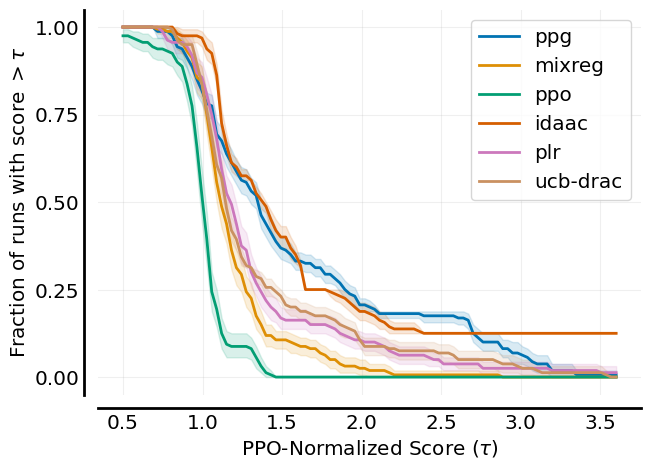

In [24]:
profile_dict = dict()
procgen_tau = np.linspace(0.5, 3.6, 101)

for algo in ppo_norm_scores.keys():
    perf = Performance(scores=ppo_norm_scores[algo], get_ci=True, reps=2000)
    profile_dict[algo] = perf.create_performance_profile(tau_list=procgen_tau)

fig, axes = plot_performance_profile(profile_dict, 
                         procgen_tau,
                         figsize=(7, 5),
                         xlabel=r'PPO-Normalized Score $(\tau)$',
                         )
fig.savefig('./plot_performance_profile.png', format='png', bbox_inches='tight')

# 3.4 plot_sample_efficiency_curve

`.plot_sample_efficiency_curve` plots an aggregate metric with CIs as a function of environment frames. An example is:

In [30]:
ale_all_frames_scores_dict = Atari().load_curves()
print(ale_all_frames_scores_dict.keys())
ale_all_frames_scores_dict['C51'].shape

dict_keys(['C51', 'DQN (Adam)', 'DQN (Nature)', 'Rainbow', 'IQN', 'REM', 'M-IQN', 'DreamerV2'])


(5, 55, 200)

We have 200 data points of 55 games over 5 random seeds.

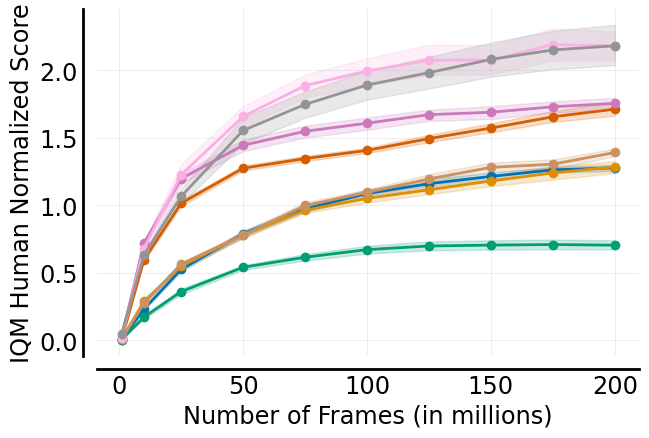

In [31]:
frames = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 200]) - 1

sampling_dict = dict()
for algo in ale_all_frames_scores_dict.keys():
    sampling_dict[algo] = [[], [], []]
    for frame in frames:
        perf = Performance(ale_all_frames_scores_dict[algo][:, :, frame],
                           get_ci=True, 
                           reps=2000)
        value, CIs = perf.aggregate_iqm()
        sampling_dict[algo][0].append(value)
        sampling_dict[algo][1].append(CIs[0]) # lower bound
        sampling_dict[algo][2].append(CIs[1]) # upper bound
    
    sampling_dict[algo][0] = np.array(sampling_dict[algo][0]).reshape(-1)
    sampling_dict[algo][1] = np.array(sampling_dict[algo][1]).reshape(-1)
    sampling_dict[algo][2] = np.array(sampling_dict[algo][2]).reshape(-1)

algorithms = ['C51', 'DQN (Adam)', 'DQN (Nature)', 'Rainbow', 'IQN', 'REM', 'M-IQN', 'DreamerV2']
fig, axes = plot_sample_efficiency_curve(
    sampling_dict,
    frames+1, 
    figsize=(7, 4.5),
    algorithms=algorithms,
    xlabel=r'Number of Frames (in millions)',
    ylabel='IQM Human Normalized Score')
fig.savefig('./plot_sample_efficiency_curve.png', format='png', bbox_inches='tight')